# Regression and Classification Methods 

In [1]:
# Importing packages
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
RAND_ST = 21
random.seed(RAND_ST)

### Load Datasets

In [3]:
def load_iris():
    iris = datasets.load_iris()
    X = iris.data
    Y = iris.target
    return X, Y

def load_mnist_dataset():
    # Load the datadet from SkDataset
    X, Y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    return X, Y

In [4]:
X, Y = load_iris()
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST)

In [5]:
X, Y = load_mnist_dataset()
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

### Data Visualisation methods

In [6]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

In [7]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

In [8]:
def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
    plt.show()

In [9]:
def plot_loss_curve(logs):
    plt.plot(logs)
    plt.show()

## Fitting

#### Normal equation solver

In [10]:
def nsolve(X,y):
    X = np.c_[np.ones((X.shape[0],1)), X]
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

##### Test normal equation solver

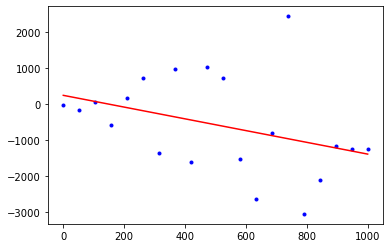

In [11]:
X = np.linspace(0,1000,20).reshape(20,1)
y = (3 * X + 20) * np.random.randn(20, 1)
w = nsolve(X,y)
preds = np.c_[np.ones(X.shape[0]), X] @ w
plt.plot(X,y, 'b.')
plt.plot(X,preds,'r')
plt.show()

#### Linear fitting

In [12]:
def line_fit(X,y):
    w = nsolve(X, y)
    y_hat = np.c_[np.ones((X.shape[0],1)), X] @ w
    l2_error = (np.square(np.subtract(y, y_preds)).sum()) ** 0.5
    return y_hat, l2_error

#### Polynomial fitting
Second order polynomial fitting

In [13]:
def poly_fit(X,y):
    matrix_cols = X.shape[1]
    for i in range(matrix_cols):
        for j in range(i, matrix_cols):
            X = np.c_[X, X[:, i] * X[:, j]]
            
    w = nsolve(X, y)
    y_hat = np.c_[np.ones(X.shape[0]), X] @ w
    l2_error = np.linalg.norm(y-y_hat)
    
    return y_hat, l2_error

## Free form optimization methods

#### Gradient Descent

In [14]:
def gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change=1.0e-6):
    minimizer  = parameters.copy()
    current_it = 0
    
    previous_step_size = eps_change + 1
    while (previous_step_size > eps_change) and (current_it < max_iterations):
        prev_parameters = parameters.copy()
        parameters = parameters - (step_size * d_objective(prev_parameters.copy()))
        previous_step_size = abs(objective(parameters.copy()) - objective(prev_parameters.copy()))
        current_it += 1        
    minimizer = parameters.copy()
    
    return minimizer, current_it + 1

#### Gradient Descent with nesterov momentum

In [15]:
def gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change):
    minimizer  = parameters.copy()
    current_it = 0
    
    previous_step_size = eps_change + 1
    theta = 0
    while (previous_step_size > eps_change) and (current_it < max_iterations):
        prev_parameters = parameters.copy()
        theta = (momentum * theta) - (step_size * d_objective(parameters + (momentum * theta)))
        parameters = parameters + theta
        previous_step_size = abs(objective(parameters.copy()) - objective(prev_parameters.copy()))
        current_it += 1        
    minimizer = parameters.copy()

    
    return minimizer, current_it + 1

#### Second order optimization

In [16]:
def second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change):
    minimizer  = parameters.copy()
    current_it = 0
    
    previous_step_size = eps_change + 1
    while previous_step_size > eps_change and current_it < max_iterations:
        prev_parameters = parameters.copy()
        parameters = parameters - (step_size * np.linalg.inv(dd_objective(parameters.copy())) @ d_objective(parameters.copy()))
        previous_step_size = abs(objective(parameters.copy()) - objective(prev_parameters.copy()))
        current_it += 1
    minimizer = parameters.copy()
    
    
    return minimizer, current_it + 1

## Clustering

#### PCA

In [17]:
def pca(X, ndims):
    mean_vec = np.mean(X, axis=0)
    cov_X = np.cov(X.T, bias=True)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_X)
    order = np.argsort(eigen_values)[::-1]
    eigen_vectors = eigen_vectors[:, order]
    top_eig_vecs = eigen_vectors[:, range(ndims)]
    top_eig_vecs = top_eig_vecs.T
    
    return mean_vec, top_eig_vecs

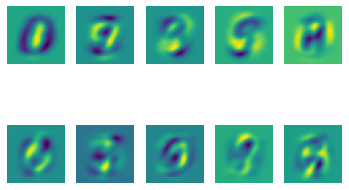

In [18]:
mean_vec, eigen_vecs = pca(X_mnist, X_mnist.shape[1])
plot_eigenvecs(eigen_vecs, 2, 5)

#### K-means

In [19]:
def kmeans(X, k, max_iterations=1000):
    rndm_mask = np.random.choice(range(X.shape[0]), k, replace=False)
    centroids = X[rndm_mask]
    assignments = np.zeros(len(X))
    
    for n in range(max_iterations):
        for i,x in enumerate(X):
            distances = ((x - centroids) ** 2).sum(axis = 1)
            closest_centroid_index = np.argmin(distances)
            assignments[i] = closest_centroid_index
        
        for i in range(len(centroids)):
            cluster_data = X[assignments == i]
            avg_centroids = cluster_data.mean(axis=0)
            centroids[i] = avg_centroids
            
    return centroids

In [ ]:
my_centroids = kmeans(X_mnist, 10)
plot_grey_image(my_centroids, 5, 2, '')

## Non-Linear Classification

In [ ]:
def gd(X, Y, W,loss_function, loss_gradient, step_size, max_it):
    current_it = 0
    history = []
    while (current_it < max_it):
        linear_preds = np.c_[np.ones(X.shape[0]), X] @ W
        history.append(loss_function(linear_preds, Y))
        W = W - (step_size * loss_gradient(linear_preds, X, Y, W))
        current_it += 1
    best_w = W
    
    return history, best_w

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, W):
    linear_preds = np.c_[np.ones(X.shape[0]), X] @ W
    preds = sigmoid(linear_preds)
    prediction = np.where(preds >= 0.5, 1, 0)    
    return prediction

In [ ]:
def logistic_loss(preds, targets):
    preds = sigmoid(preds)
    cost = (-targets * np.log(preds) - (1 - targets) * np.log(1 - preds)).mean()
    return cost

In [ ]:
def dlogistic(preds, X, Y,W=[]):
    preds = sigmoid(preds)
    J = np.dot(np.c_[np.ones(X.shape[0]), X].T, (preds - Y)) / Y.shape[0]
    return J

In [ ]:
my_W = np.ones(X_iris.shape[1]+1)
my_X = X_iris
my_Y = np.where(Y_iris == 0, 0, 1)
my_history, my_best_W = gd(my_X, my_Y, my_W, logistic_loss, dlogistic, 0.001, 10000)
log_ys = predict(X_iris_test, my_best_W)
plot_confusion_matrix(log_ys, np.where(Y_iris_test == 0, 0, 1))
plot_loss_curve(my_history)

In [ ]:
def hinge_loss(z, Y):
    Y = np.where(Y==0, -1, 1)
    avg = np.mean([max(0, 1-x*y) for x, y in zip(Y, z)])
    return avg


def dhinge(preds,X, Y, W=[]):
    X = np.c_[np.ones(X.shape[0]), X]
    Y = np.where(Y==0, -1, 1)
    results = (Y * (X@W))
    for i in range(0, len(results)):
        if results[i] <= 1:
            W = W - Y[i] * X[i]
    J = W
    return J

In [ ]:
rnd_W = np.random.rand(X_iris.shape[1]+1)
my_history, my_best_W = gd(X_iris, np.where(Y_iris == 0, 0, 1), rnd_W, hinge_loss, dhinge, 1e-4, 1000)

hinge_preds = predict(X_iris_test, my_best_W)
plot_confusion_matrix(hinge_preds, np.where(Y_iris_test == 0, 0, 1))
plot_loss_curve(my_history)

## Neural networks

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dsigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [ ]:
def forward_pass(x, W, b):
    z1 = np.dot(x, W[0]) + b[0]
    a1 = sigmoid(z1)
    
    z2 = np.dot(a1, W[1]) + b[1]
    a2 = sigmoid(z2)
    
    z3 = np.dot(a2, W[2]) + b[2]
    a3 = sigmoid(z3)
    
    y_hat = a3
    cache = (z1,a1,z2,a2,z3,a3)
    
    
    return y_hat, cache

In [ ]:
def loss(preds, targets):
    return np.mean(((preds - targets)) ** 2)

def dloss(preds, target):
    return preds - target

In [ ]:
def backward_pass(preds, targets, W, b, X, cache):
    d_error = dloss(preds, targets) / 64
    
    J_w3 = (d_error.T @ cache[3]).T
    J_w2 = (((d_error @ W[2].T) * dsigmoid(cache[2])).T @ cache[1]).T
    J_w1 =( ((((d_error @ W[2].T) * dsigmoid(cache[2])) @ W[1].T ) * dsigmoid(cache[0])).T @ X).T

    J_b3 = np.sum(d_error,axis = 0)
    J_b2 = np.sum((d_error @ W[2].T) * dsigmoid(cache[2]), axis=0)
    J_b1 = np.sum((((d_error @ W[2].T) * dsigmoid(cache[2])) @  W[1].T) * dsigmoid(cache[0]) ,axis=0)
    
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

In [ ]:
def training(X, Y, W, b, step_size, max_it):
    batch = 64
    history = []
    for iteration in range(max_it):
        loss_ = 0
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]
               
        for i in range(int(X.shape[0] / batch)):
            start = i*batch
            end = (i+1)*batch
            
            x = X[start: end]
            y = Y[start: end]
            y_hat, cache = forward_pass(x,W,b)
            J_w3, J_w2, J_w1, J_b3, J_b2, J_b1 = backward_pass(y_hat, y, W, b, x, cache)
            W = list(W)
            b = list(b)
            W[2] = W[2] - step_size * J_w3
            W[1] = W[1] - step_size * J_w2
            W[0] = W[0] - step_size * J_w1
            
            b[2] = b[2] - step_size * J_b3
            b[1] = b[1] - step_size * J_b2
            b[0] = b[0] - step_size * J_b1
            loss_ = loss_ + loss(y_hat, y)
        history.append(loss_/int(X_mnist.shape[0]/batch))    
    return W, b, history

In [ ]:
one_hot_y = np.zeros((Y_mnist.shape[0], 10))
for i in range(Y_mnist.shape[0]):
    one_hot_y[i][Y_mnist[i]] = 1

W_1 = np.random.randn(X_mnist.shape[1],256)
W_2 = np.random.randn(W_1.shape[1],128)
W_3 = np.random.randn(W_2.shape[1],one_hot_y.shape[1])
W_ = (W_1,W_2,W_3)

b_1 = np.random.randn(W_1.shape[1],)
b_2 = np.random.randn(W_2.shape[1],)
b_3 = np.random.randn(W_3.shape[1],)
b_ = (b_1,b_2,b_3)

#may take long time to compute (depending on no. iterations)
W, b, histories = training(X_mnist, one_hot_y , W_ , b_, 1e-2, 200)
plot_loss_curve(histories)

calculate accuracy of model by forward passing test set

In [ ]:
y_hat, cache = forward_pass(X_mnist_test, W, b)
preds = np.argmax(y_hat, axis=1)
accuracy = np.where(preds == Y_mnist_test, 1, 0).mean()
print(f'accuracy: {round(accuracy*100,2)}%')